In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_excel('result.xlsx')

In [3]:
import pandas as pd
from Levenshtein import ratio
import re

string_columns = ['formula', 'surface', 'syngony']

syngony_dict = {
    0: "amorphous",
    1: "triclinic",
    2: "monoclinic",
    3: "orthorhombic",
    4: "tetragonal",
    5: "trigonal",
    6: "hexagonal",
    7: "cubic"
}

def clean_string(s):
    return re.sub(r'[\s\-@]+', '', str(s)).lower()

def convert_syngony(value):
    try:
        numeric_value = int(value)
        return syngony_dict.get(numeric_value, value)
    except (ValueError, TypeError):
        return value

def calculate_levenshtein_ratio(row):
    levenshtein_ratios = {}
    for col in string_columns:
        test_col = col + '_test'
        assist_col = col + '_assist'
        
        if col == 'syngony':
            row[test_col] = convert_syngony(row[test_col])
            row[assist_col] = convert_syngony(row[assist_col])
        
        if test_col in row and assist_col in row:
            value_test = clean_string(row.get(test_col, ''))
            value_assist = clean_string(row.get(assist_col, ''))
            
            if pd.notna(value_test) and pd.notna(value_assist) and value_test and value_assist:
                levenshtein_ratios[col] = round(1 - ratio(value_test, value_assist),2)
            else:
                levenshtein_ratios[col] = 1
        else:
            # print(f"Колонки {test_col} и {assist_col} отсутствуют в строке")
            levenshtein_ratios[col] = 1
    return levenshtein_ratios


levenshtein_results = df.apply(calculate_levenshtein_ratio, axis=1)
levenshtein_df = pd.DataFrame(list(levenshtein_results))

final_df = pd.concat([df, levenshtein_df], axis=1)


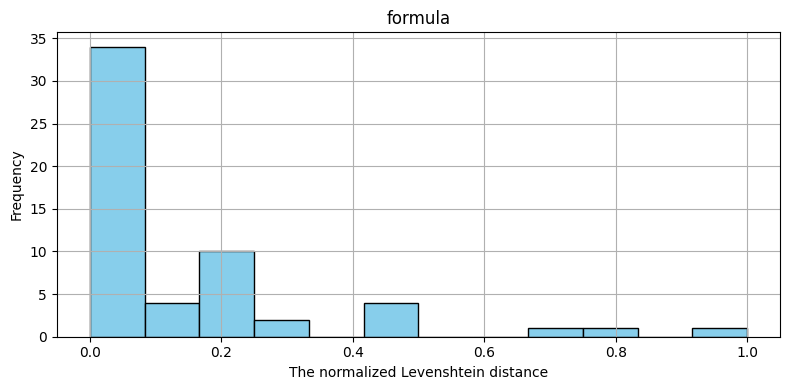

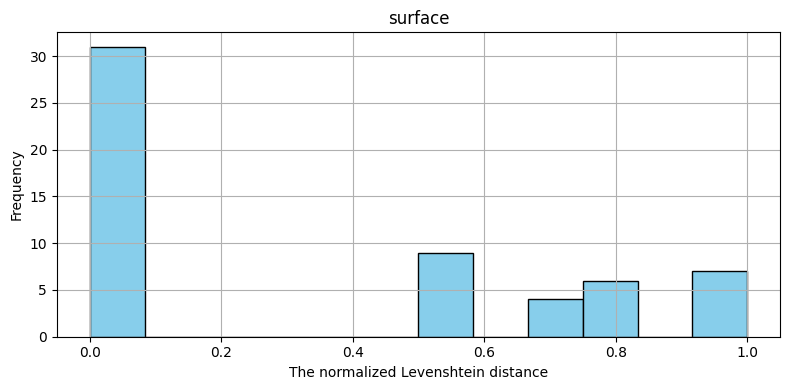

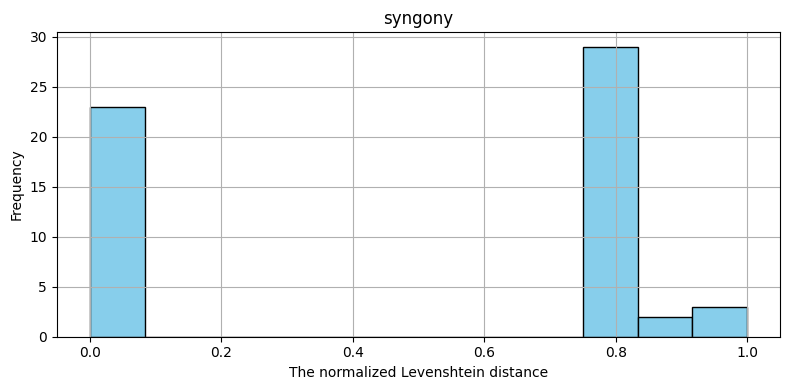

In [4]:
columns_to_plot = ['formula', 'surface', 'syngony']

for column in columns_to_plot:
    plt.figure(figsize=(8, 4))
    
    sorted_values = final_df[column].sort_values()
    
    plt.hist(sorted_values, bins=12, edgecolor='black', color='skyblue')
    
    plt.title(f'{column}')
    plt.xlabel('The normalized Levenshtein distance')
    plt.ylabel('Frequency')
    
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

In [5]:
import pandas as pd

numeric_columns = ['length', 'width', 'depth', 'km', 'c_min', 'c_max', 'c_const', 'ccat', 'ph', 'temperature', 'v_max',
]

def calculate_precision_recall(final_df, numeric_columns):
    metrics = {}
    
    for column in numeric_columns:
        correct_matches = (final_df[f'{column}_test'] == final_df[f'{column}_assist']) & (final_df[f'{column}_assist'] != 0)
        
        df_no_na = final_df.dropna(subset=[f'{column}_test', f'{column}_assist'])
        
        valid_rows = (df_no_na[f'{column}_test'] != 0) | (df_no_na[f'{column}_assist'] != 0)

        correct_matches = correct_matches & valid_rows
        
        correct_count = correct_matches.sum()

        total_assist = df_no_na[(df_no_na[f'{column}_assist'] != 0) & valid_rows].shape[0]
    
        total_test = df_no_na[df_no_na[f'{column}_test'] != 0].shape[0]
        
        precision = correct_count / total_assist if total_assist > 0 else 0
        recall = correct_count / total_test if total_test > 0 else 0
        
        metrics[column] = {
            'precision': round(precision,2),
            'recall': round(recall,2)
        }
    
    return metrics

metrics = calculate_precision_recall(final_df, numeric_columns)

metrics_df = pd.DataFrame(metrics).transpose()


In [6]:
metrics_df

,precision,recall
km,0.97,0.91
c_min,0.97,0.54
c_max,0.97,0.53
c_const,0.78,0.51
ccat,0.88,0.81
ph,0.98,0.82
temperature,0.70,0.96
v_max,0.96,0.83
length,0.66,0.55
width,0.56,0.35
